In [1]:
%matplotlib inline
import torch
from torch import nn
from torch.autograd import Variable
import math
import numpy as np
from torch.nn import functional as F
import matplotlib.pyplot as plt
from deepvoice3_pytorch.modules import position_encoding_init

/Users/yusuke/anaconda3/envs/deepvoice3/lib/python3.5/site-packages/matplotlib/font_manager.py:281: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


$\mathrm{PE}_{\mathrm{pos}, 2i} = \sin(\mathrm{pos}/10000^{2i/d_{\mathrm{model}}})$

$\mathrm{PE}_{\mathrm{pos}, 2i+1} = \cos(\mathrm{pos}/10000^{2i/d_{\mathrm{model}}})$

where `pos` is the position and `i` is the dimension.

In [2]:
# position_encoding_init
''' Init the sinusoid position encoding table '''
d_pos_vec = 3
position_rate=1.0
n_position = 5

position_enc = [
    [position_rate * pos / np.power(10000, 2 * (i // 2) / d_pos_vec) for i in range(d_pos_vec)]
    if pos != 0 else np.zeros(d_pos_vec) for pos in range(n_position)]

position_enc = np.array(position_enc)
position_enc

array([[  0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  1.00000000e+00,   1.00000000e+00,   2.15443469e-03],
       [  2.00000000e+00,   2.00000000e+00,   4.30886938e-03],
       [  3.00000000e+00,   3.00000000e+00,   6.46330407e-03],
       [  4.00000000e+00,   4.00000000e+00,   8.61773876e-03]])

In [3]:
position_enc_sinusoidal = torch.from_numpy(position_enc).float()
position_enc_sinusoidal[1:, 0::2] = torch.sin(position_enc_sinusoidal[1:, 0::2]) # 2i
position_enc_sinusoidal[1:, 1::2] = torch.cos(position_enc_sinusoidal[1:, 1::2]) # 2i + 1

position_enc_sinusoidal


 0.0000  0.0000  0.0000
 0.8415  0.5403  0.0022
 0.9093 -0.4161  0.0043
 0.1411 -0.9900  0.0065
-0.7568 -0.6536  0.0086
[torch.FloatTensor of size 5x3]

In [4]:
def sinusoidal_encode(x, w):
    y = w * x
    y[1:, 0::2] = torch.sin(y[1:, 0::2].clone())
    y[1:, 1::2] = torch.cos(y[1:, 1::2].clone())
    return y

In [5]:
# class SinusoidalEncoding(nn.Embedding)

help(nn.Embedding)
    

Help on class Embedding in module torch.nn.modules.sparse:

class Embedding(torch.nn.modules.module.Module)
 |  A simple lookup table that stores embeddings of a fixed dictionary and size.
 |  
 |  This module is often used to store word embeddings and retrieve them using indices.
 |  The input to the module is a list of indices, and the output is the corresponding
 |  word embeddings.
 |  
 |  Args:
 |      num_embeddings (int): size of the dictionary of embeddings
 |      embedding_dim (int): the size of each embedding vector
 |      padding_idx (int, optional): If given, pads the output with zeros whenever it encounters the index.
 |      max_norm (float, optional): If given, will renormalize the embeddings to always have a norm lesser than this
 |      norm_type (float, optional): The p of the p-norm to compute for the max_norm option
 |      scale_grad_by_freq (boolean, optional): if given, this will scale gradients by the frequency of
 |                                           

In [6]:
class SinusoidalEncoding(nn.Embedding):
    def __init__(self, num_embeddings, embedding_dim, padding_idx=0, *args, **kwargs):
        super(SinusoidalEncoding, self).__init__(num_embeddings, embedding_dim, padding_idx, *args, **kwargs)
        self.weight.data = position_encoding_init(num_embeddings, embedding_dim, position_rate, sinusoidal=False)
    
    def forward(self, x, w=1.0):
        assert np.isscalar(w)
        weight = sinusoidal_encode(self.weight, w)
        return self._backend.Embedding.apply(
            x, weight, self.padding_idx, self.max_norm, self.norm_type, self.scale_grad_by_freq, self.sparse
        )

In [7]:
# test_sinusoidal

num_embedding = 512
embedding_dim = 128
padding_idx = 0

a = nn.Embedding(num_embedding, embedding_dim, padding_idx=padding_idx)
a.weight.data = position_encoding_init(num_embedding, embedding_dim, position_rate=1.0)

b = SinusoidalEncoding(num_embedding, embedding_dim, padding_idx=padding_idx)

x = Variable(torch.arange(0, 128).long())

w = 1.0

ax = a(x).data.numpy()
bx = b(x, w).data.numpy()

np.abs(ax - bx).mean()

0.0

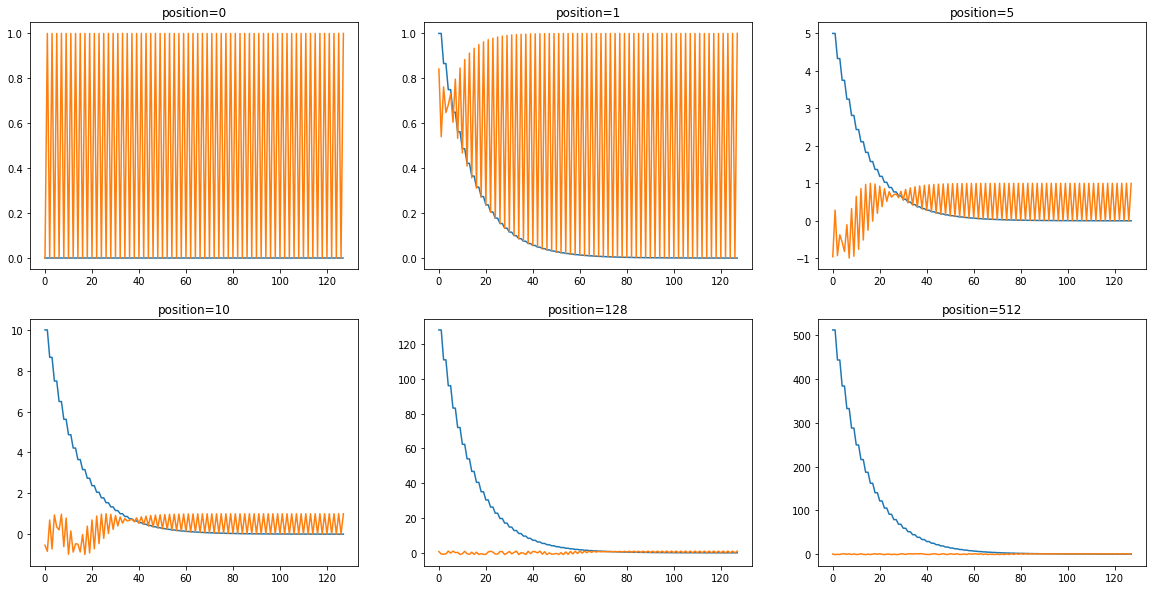

In [30]:
d_pos_vec = 128

def single_position(position_idx, d_pos_vec, position_rate=1.0):
    pos = [position_rate * position_idx / np.power(10000, 2 * (i // 2) / d_pos_vec) for i in range(d_pos_vec)]
    pos_sinusoidal = pos.copy()

    pos_sinusoidal[0::2] = np.sin(pos_sinusoidal[0::2])
    pos_sinusoidal[1::2] = np.cos(pos_sinusoidal[1::2])
    return pos, pos_sinusoidal

plt.figure(figsize=(20, 10))

for i, pos in enumerate([0, 1, 5, 10, 128, 512], 1):
    pos_exp, pos_sinusoidal = single_position(pos, d_pos_vec)
    plt.subplot(2,3, i)
    plt.title("position={}".format(pos))
    plt.plot(pos_exp)
    plt.plot(pos_sinusoidal)
